In [53]:
import datetime as dt
import os
from typing import *
import time

import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import Callback

class SGDRScheduler_warmup(Callback):       #modified to have warmup every restart
    '''Cosine annealing learning rate scheduler with periodic warmup restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=30,
                                     cycle_mult_factor=2,
                                     warmup_length=10,
                                     warmup_mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        cycle_mult_factor: Scale cycle_length after each full cycle completion.
        warmup_length: Number of epochs for warmup during every restart. #minimum 1
        warmup_mult_factor: Scale warmup_length after each full cycle completion.
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        See [Loshchilov & Hutter, ICLR2016], SGDR: Stochastic Gradient Descent
        with Warm Restarts. https://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay,
                 cycle_length,
                 cycle_mult_factor,
                 warmup_length,
                 warmup_mult_factor):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps_per_epoch = steps_per_epoch
        self.lr_decay = lr_decay
        self.cycle_length = cycle_length
        self.cycle_mult_factor = cycle_mult_factor
        if warmup_length == 0:
            warmup_length = 1
        self.warmup_length = warmup_length
        self.warmup_mult_factor = warmup_mult_factor
        
        self.batch_since_restart = 0
        self.batch_since_warmup = 0
        self.warmup_cycle_mode = 0  #warmup =0, cycle=1
        self.next_restart = warmup_length #we start with warmup
        self.flag = 0

        self.history = {}

    def clr(self):
        '''Calculate the learning rate cosine fall.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr
    
    def warmup_clr(self):
        '''Calculate the learning rate during warmup.'''
        fraction_to_restart = self.batch_since_warmup / (self.steps_per_epoch * self.warmup_length)
        #lr = self.min_lr + (self.max_lr - self.min_lr) * fraction_to_restart
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 - np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        #K.set_value(self.model.optimizer.lr, self.max_lr) # when no warmup
        K.set_value(self.model.optimizer.lr, self.min_lr) # when warmup we start from lowest lr

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        if self.warmup_cycle_mode==0:
            K.set_value(self.model.optimizer.lr, self.warmup_clr()) 
            self.batch_since_warmup += 1     
        if self.warmup_cycle_mode==1:
            K.set_value(self.model.optimizer.lr, self.clr())
            self.batch_since_restart += 1
            

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.warmup_cycle_mode = not self.warmup_cycle_mode # swap 0 to 1 and vice versa
            
            self.batch_since_restart = 0
            self.batch_since_warmup = 0
            
            if self.warmup_cycle_mode==0: 
                self.warmup_length = np.ceil(self.warmup_length * self.warmup_mult_factor)
                self.next_restart += self.warmup_length
            if self.warmup_cycle_mode==1: 
                self.cycle_length = np.ceil(self.cycle_length * self.cycle_mult_factor)
                self.next_restart += self.cycle_length
            self.flag = self.flag + 1
            if self.flag == 1:
                self.warmup_length = 1           
            if self.flag == 2:
                self.max_lr = self.max_lr * 0.5
                self.warmup_length = 1
            else:
                self.max_lr *= self.lr_decay
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)  


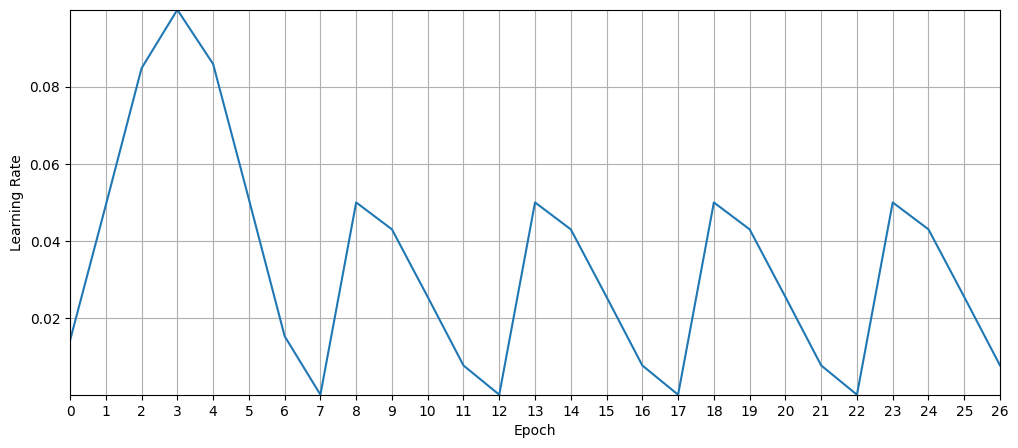

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

# create a dummy model with an optimizer
model = Sequential()  # this is a placeholder and won't actually be used for training
model.add(Dense(1, input_dim=1))  # add a simple layer just to define an input shape
model.compile(optimizer=Adam())  # the optimizer type doesn't matter here

sgdr = SGDRScheduler_warmup(
    min_lr=1e-5, 
    max_lr=0.1, 
    steps_per_epoch=50,  # change this to the number of batches in an epoch for your specific dataset
    lr_decay=1, 
    cycle_length=4, 
    cycle_mult_factor=1,
    warmup_length=4,
    warmup_mult_factor=1
)

sgdr.set_model(model)  # attach the dummy model to the scheduler

# simulate 200 epochs
num_epochs = 27
learning_rates = []

for epoch in range(num_epochs):
    # simulate steps_per_epoch batches
    for _ in range(sgdr.steps_per_epoch):
        sgdr.on_batch_end(None)
    learning_rates.append(K.get_value(sgdr.model.optimizer.lr))
    sgdr.on_epoch_end(epoch)

# plot the learning rate schedule
fig = plt.figure(figsize=(12, 5))
plt.plot(np.arange(num_epochs), learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.margins(0)
plt.xticks(np.arange(num_epochs))
plt.grid()
plt.show()

K.clear_session()
del model, sgdr, learning_rates, num_epochs, epoch

